In [1]:
import numpy
import matplotlib.pyplot as plt
from skimage.transform import resize
import itertools
import random
import tqdm
clean = numpy.load('/Users/remydubois/Desktop/Remy/_REMY/Segmentation/data/sequences_clean.npy')

In [2]:
def _flip(m, axis=0):
    cop = m.copy()
    cop[:, axis] = cop[:, axis].max() - cop[:, axis]
    return cop


def _transpose(m):
    return m[:, ::-1]


def _length(m):
    return numpy.sqrt(numpy.sum(numpy.square(m[1:] - m[:-1]), axis=1)).sum()


def _scale(m):
    l = _length(m)
    return m.astype(float) / l


def _stretch(m, ratios):
    assert min(ratios) > 0, "Ratios should be strictly positive."
    n = (m - numpy.mean(m, axis=0).astype(int)) * ratios
    # print(n, 'min', numpy.min(n, axis=0))
    return n - numpy.min(n, axis=0)


def _deconstruct(m):
    return m[1:] - m[:-1]


def _reconstruct(m):
    start = numpy.zeros((m.shape[0] + 1, m.shape[1]))
    progression = numpy.cumsum(numpy.vstack([[0, 0], m]), axis=0)
    return start + progression


def sample(m, n_points=200):
    out = resize(m, (n_points, 2), preserve_range=True, mode='constant')
    return out


def rot0(m):
    return m


def rot90(m):
    return _transpose(_flip(m, 0))


def rot180(m):
    return _flip(_flip(m, 1), 0)


def rot270(m):
    return _flip(_transpose(m), 0)



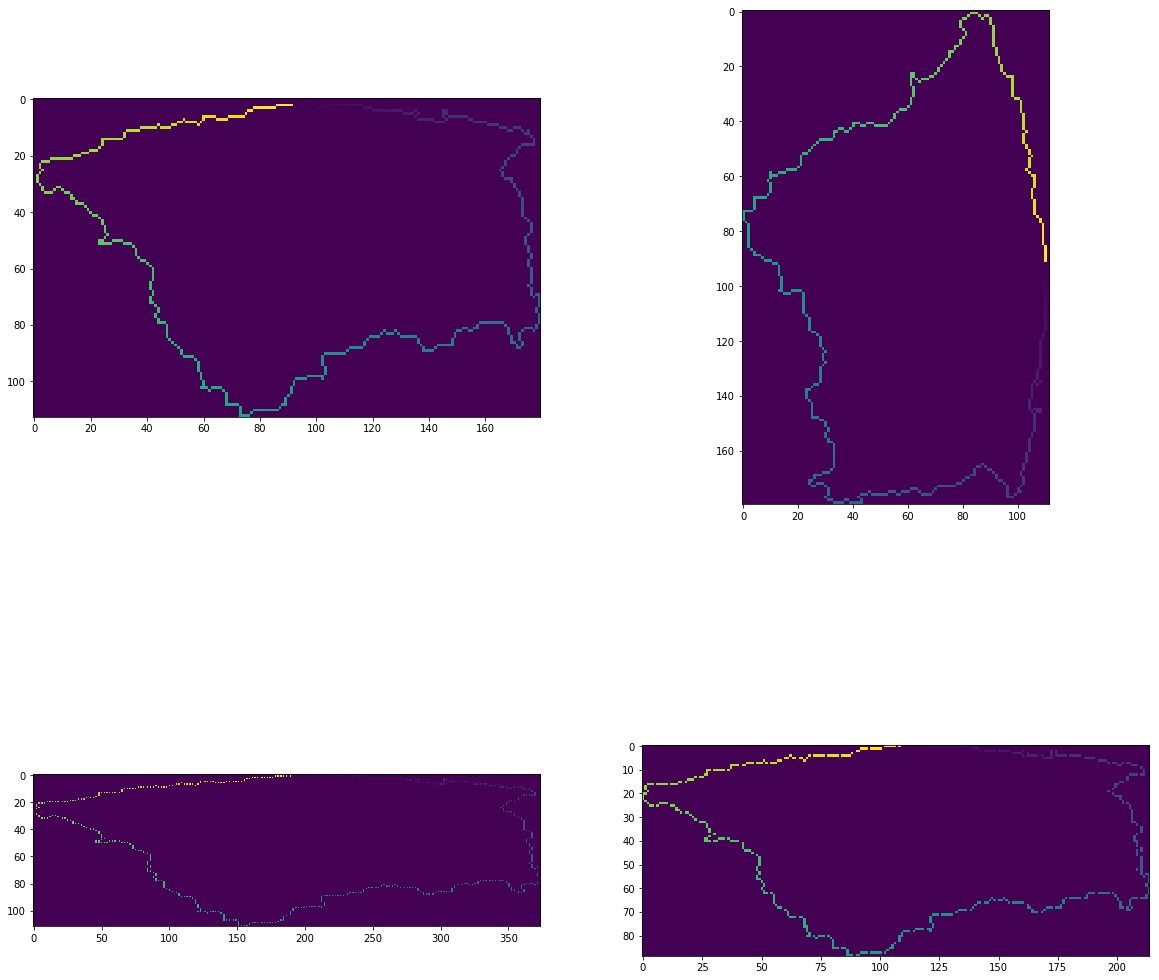

In [27]:
base = clean[0][0]
ms = [base, rot90(base), _stretch(base, [1, 2.1]), _stretch(base, [0.8, 1.2])]

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax = iter(ax.ravel())
for m in ms:
    m = m.astype(int)
    o = numpy.zeros(numpy.max(m, axis=0)+1) 
    for i, t in enumerate(m):
        o[tuple(t)] = i
    next(ax).imshow(o)

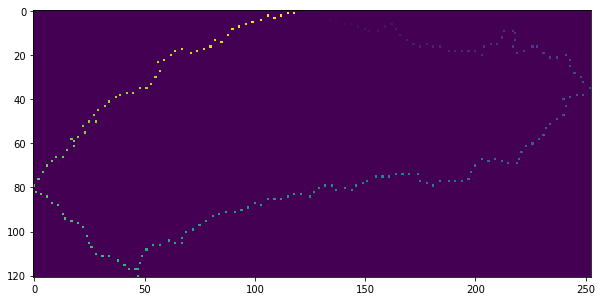

In [53]:
from skimage.transform import resize


def show(base):
    f, ax = plt.subplots(figsize=(10, 10))
    m = sample(base)
    m = m.astype(int)
    n = m - numpy.min(m, axis=0)
    o = numpy.zeros(numpy.max(n, axis=0)+1) 
    for i, t in enumerate(n):
        o[tuple(t)] = i
    ax.imshow(o)
    
    
show(clean[10][0])

In [3]:
def routine(x):
    # filter out small sequences (looking at histograms of length)
    ds = filter(lambda t: t.shape[0] > 200, x)
    
    # downsample sequences with a proper rescaling (not just integer slicing)
    ds = map(lambda m: sample(m, 201), ds)
    
    return ds


def cut_sequences(X):
    return numpy.concatenate([numpy.roll(X, i, 1) for i in range(X.shape[1] - 1)], axis=0)

    
def preprocess(x):
    return map(lambda m: _scale(_deconstruct(m)), x)    


def augmentor(*ops):
    print
    def g(it):
        return itertools.cycle(map(lambda m: ops[random.randint(0, len(ops) - 1)](m), it))
    
    return g
        

# db = routine(list(zip(*clean))[0])
# db = augmentor(rot0, rot90, rot180, rot270, lambda m: _stretch(m, [1.2, 1]), lambda m: _stretch(m, [1, 1.4]))(db)
# dbp = preprocess(db) 



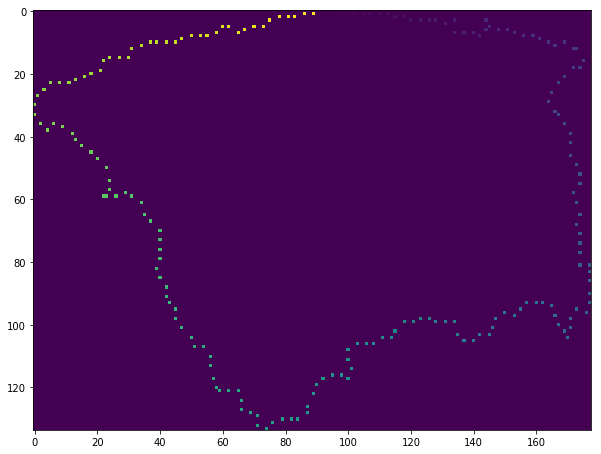

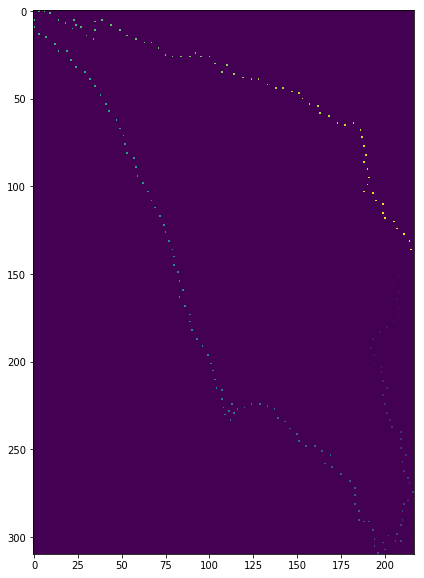

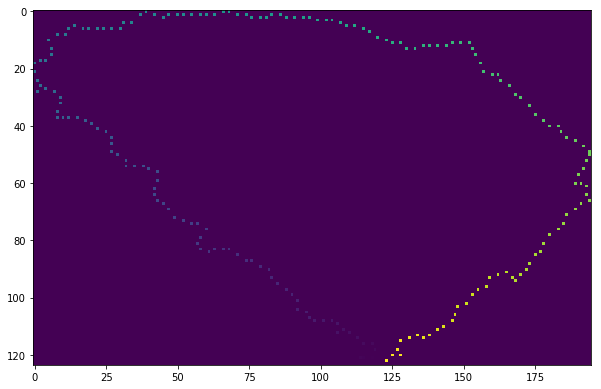

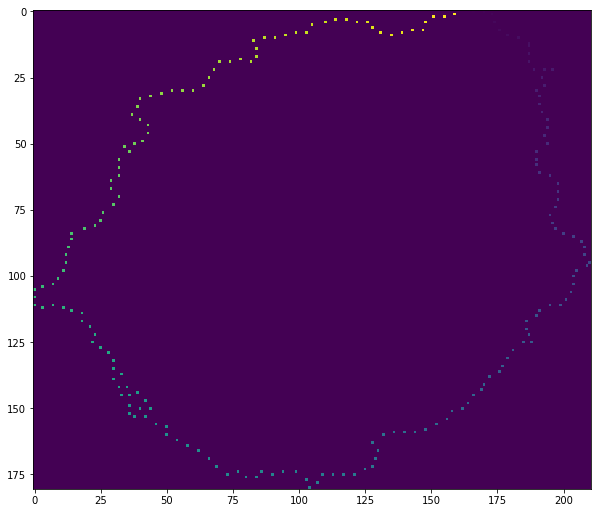

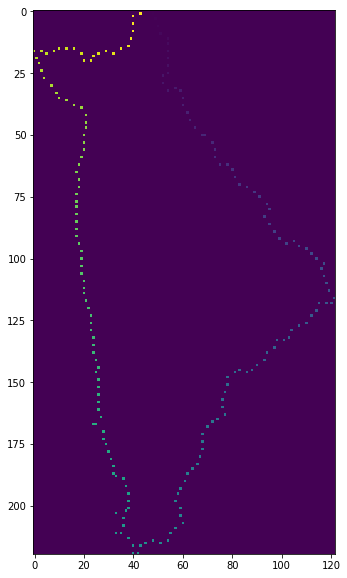

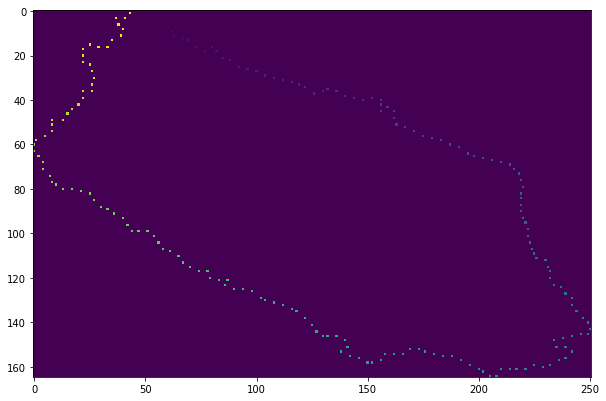

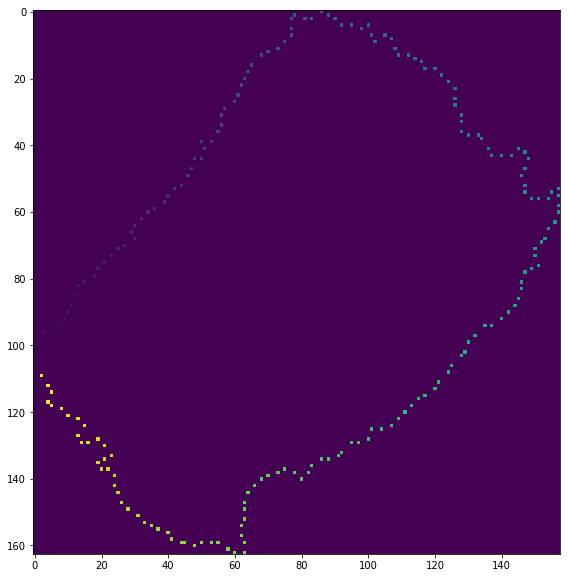

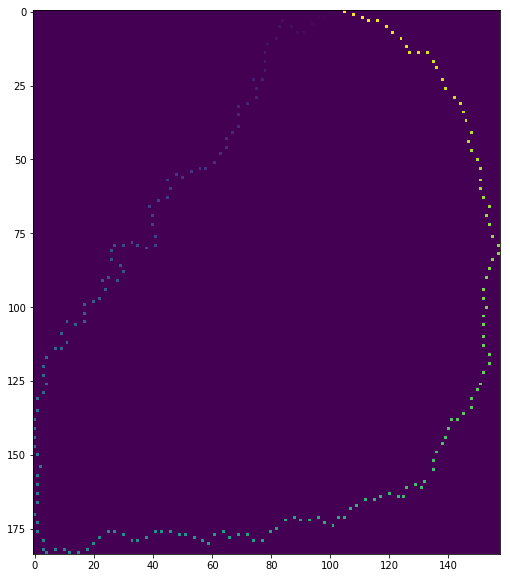

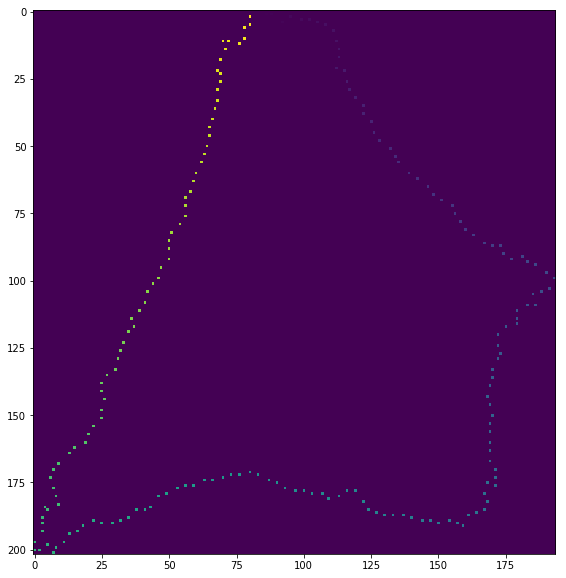

In [30]:
show(next(db))
show(next(db))
show(next(db))
show(next(db))
show(next(db))
show(next(db))
show(next(db))
show(next(db))
show(next(db))

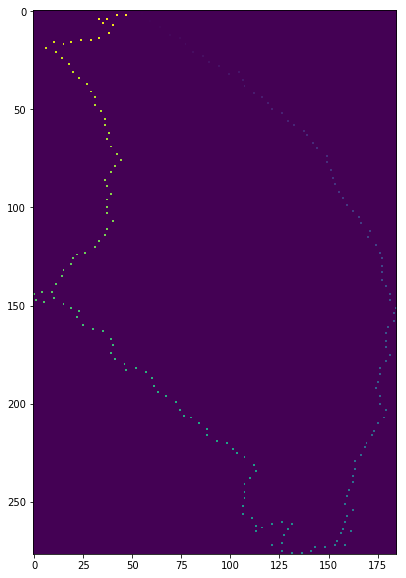

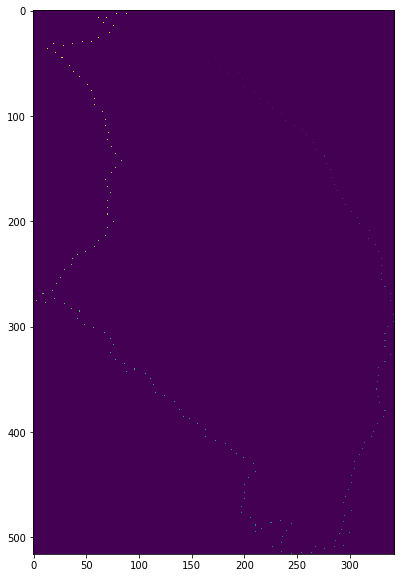

In [31]:

s1 = next(db)
show(s1)
s2 = _scale(_deconstruct(s1))
s2 = (s2 * _length(s1))
m = _reconstruct(s2).astype(int)
show(_reconstruct(_scale(_deconstruct(s1))) * _length(s1))
# print(_reconstruct(_deconstruct(s1)) - s1)

In [4]:
from keras.layers import GRU, Input, GRUCell, Dropout, Dense, LSTM
from keras.models import Model
from keras.optimizers import adagrad, adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

train_set, test_set = train_test_split(list(zip(*clean))[0], train_size=0.8, test_size=0.2)


def batch_generator(it, batch_size=30):
    # it = itertools.cycle(it)
    it = routine(it)
    X = numpy.stack(list(it), axis=0)
    X = cut_sequences(X)
    numpy.random.shuffle(X)
    db = itertools.cycle(X)
    db = augmentor(rot0, lambda m: _stretch(m, [1.2, 1]), lambda m: _stretch(m, [1, 1.4]))(db)
    dbp = preprocess(db)

    while True:
        seqs = numpy.stack([dbp.__next__() for _ in range(batch_size)], axis=0)
        yield seqs[:, :199, :], numpy.squeeze(seqs[:, 199, :])


input_ = Input(shape=(199, 2))
x = LSTM(128, activation='relu', return_sequences=True)(input_)
x = Dropout(0.2)(x)
x = LSTM(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2)(x)
model = Model(input_, x)

ada = adam()
model.compile(optimizer=ada, loss='mean_squared_error')
earl = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
train = batch_generator(train_set, 400)
test = batch_generator(test_set, 400)
model.fit_generator(train,
                    steps_per_epoch=43000 // 400,
                    validation_data=test,
                    validation_steps=10600 // 400,
                    epochs=9,
                    callbacks=[earl]
                    )


Using TensorFlow backend.


Epoch 1/9


  1/107 [..............................] - ETA: 10:10 - loss: 4.6781e-05

  2/107 [..............................] - ETA: 7:40 - loss: 4.5717e-05 

  3/107 [..............................] - ETA: 6:51 - loss: 4.5709e-05

  4/107 [>.............................] - ETA: 6:23 - loss: 4.4371e-05

  5/107 [>.............................] - ETA: 6:06 - loss: 4.3496e-05

  6/107 [>.............................] - ETA: 5:54 - loss: 4.3078e-05

  7/107 [>.............................] - ETA: 5:43 - loss: 4.2340e-05

  8/107 [=>............................] - ETA: 5:35 - loss: 4.2008e-05

KeyboardInterrupt: 

NameError: name 'model' is not defined

In [28]:
from keras.models import model_from_json
model = model_from_json(open('/Users/remydubois/Dropbox/Remy/results/rnnseq/architecture.json').read())
model.summary()
model.load_weights('/Users/remydubois/Dropbox/Remy/results/rnnseq/model-ckpt')

seeder = batch_generator(list(zip(*clean))[0], batch_size=1)
seed = seeder.__next__()[0]

for i in tqdm.tqdm(range(1, 200), disable=False):
    # print(seed[:, -10:])    
    next = model.predict(seed)
    seed = numpy.concatenate((seed, next[numpy.newaxis, ...]), 1)[:, 1:, :]
boundary = _reconstruct(seed[0]*1000)

def show_2(m):
    f, ax = plt.subplots(figsize=(10, 10))
    # m = sample(base)
    m = m.astype(int)
    n = m - numpy.min(m, axis=0)
    o = numpy.zeros(numpy.max(n, axis=0)+1) 
    for i, t in enumerate(n):
        o[tuple(t)] = i
    ax.imshow(o)
    
show_2(boundary)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 199, 2)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 199, 128)          67072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 116,610
Trainable params: 116,610
Non-trainable params: 0
_________________________________________________________________


InvalidArgumentError: Node 'IsVariableInitialized_538': Unknown input node 'gru_15/kernel'

In [19]:
print(seed[0]*1000)

[[ -7.60045368  -2.75412318]
 [ -7.63943978  -2.70465435]
 [ -7.4944282   -2.88847648]
 [ -7.29375891  -3.14452499]
 [ -7.07299262  -3.42237111]
 [ -6.84198923  -3.70785291]
 [ -6.60058018  -3.99312563]
 [ -6.34666113  -4.27217223]
 [ -6.08205143  -4.54736594]
 [ -5.80824632  -4.82051773]
 [ -5.52637409  -5.09305857]
 [ -5.23725431  -5.36611956]
 [ -4.94147884  -5.64058498]
 [ -4.64132754  -5.91617078]
 [ -4.33853921  -6.19245274]
 [ -4.03838232  -6.45085704]
 [ -3.74286412  -6.69452408]
 [ -3.44150723  -6.93198852]
 [ -3.13329231  -7.16603687]
 [ -2.82169273  -7.39685167]
 [ -2.50795926  -7.62510067]
 [ -2.19266093  -7.85143115]
 [ -1.87612115  -8.07636417]
 [ -1.55855808  -8.30030907]
 [ -1.24872942  -8.51251557]
 [ -0.95202797  -8.70714989]
 [ -0.66499063  -8.89049098]
 [ -0.39949105  -9.05406661]
 [ -0.15231897  -9.20238346]
 [  0.07515401  -9.33358632]
 [  0.28207037  -9.44654085]
 [  0.46964618  -9.54313576]
 [  0.63714175  -9.62488074]
 [  0.78517455  -9.69386008]
 [  0.91546611